# GLAFT Quick Start

GLAcier Feature Tracking testkit (GLAFT) calculates two metrics for visualizing and benchmarking the quality of glacier velocity maps. Here we describe its basic usage.

## Input files

To begin, the following files are necessary:

1. **Velocity map as two files**; one showing the $V_x$ component and the other showing $V_y$. GLAFT accepts any raster format readable by the Python rasterio package, and we recommend GeoTiff as the preferred format.

2. **Polygon geometries indicating static terrain or ice flow locations**. GLAFT uses the Python geopandas module to parse the geometries. While there are many compatible formats, we recommend using ESRI shapefile for these geometries since this format has been tested. The other common formats should work too, such as geopackage or geojson, but please use them with discretion as if you choose to. Polygon geometries must use the **same coordinate reference system (CRS)** as the velocity maps.  

## Procedure

First, import the GLAFT module,

In [1]:
import glaft

and specify the input velocity maps and polygon geometries. We use one of the test pairs presented in the [GLAFT publication](https://doi.org/10.5194/tc-17-4063-2023) as a demo: Kaskawulsh glacier velocity between March 4 and April 5, 2018, processed with the CARST software with the following key parameters. More details are available in the paper.

- Image source: Landsat 8
- Matching template size: 64 pixels (960 m)
- Output resolution (aka skip size): 4 pixels (60 m) 
- Pre-processing filter: Gaussian filter 

In [2]:
vx = 'demo-data/20180304-20180405_velo-raw_vx.tif'
vy = 'demo-data/20180304-20180405_velo-raw_vy.tif'
static_area  = 'demo-data/bedrock_V2.shp'
iceflow_area = 'demo-data/glacier_V1_Kaskawulsh_s_inwardBuffer600m.shp'

### Checking input files

GLAFT has a function called `show_velocomp` to visualize the input raster. 

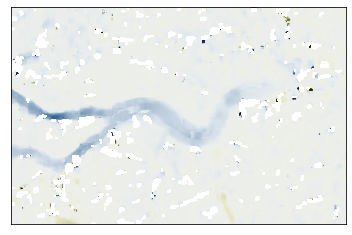

In [3]:
glaft.show_velocomp(vx);

To prepare and show colorbar, we can use the `prep_colorbar_mappable` function:

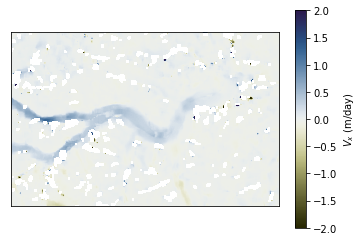

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
cm_settings = glaft.show_velocomp(vx, ax=ax)

mappable = glaft.prep_colorbar_mappable(**cm_settings)
fig.colorbar(mappable, label='$V_x$ (m/day)');

GLAFT does not provide functions to visualize and check the polygon geometries since we can simply use geopandas to achieve that.

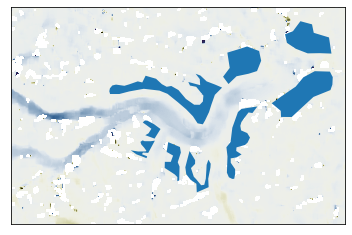

In [5]:
import geopandas as gpd

fig, ax = plt.subplots(1, 1)
_ = glaft.show_velocomp(vx, ax=ax)

polygons = gpd.read_file(static_area)
polygons.plot(ax=ax);

### Metric 1: Correct-match uncertainty on static terrains

To calculate Metric 1, we construct a `glaft.Velocity` object with all necessary files as arguments.

In [6]:
experiment = glaft.Velocity(vxfile=vx, vyfile=vy, static_area=static_area)

And then we can use the method `static_terrain_analysis` to perform the entire analysis. This method is essentially a wrapper script containing eleven steps for calculating kernel density estimate (KDE).

In [7]:
experiment.static_terrain_analysis()

Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent


Now the metric and the other derived values are accessible via the following object attributes.

In [8]:
print('delta_x: {:.4} (m/day)'.format(experiment.metric_static_terrain_x))
print('delta_y: {:.4} (m/day)'.format(experiment.metric_static_terrain_y))
print('KDE peak location x: {:.4} (m/day)'.format(experiment.kdepeak_x))
print('KDE peak location y: {:.4} (m/day)'.format(experiment.kdepeak_y))
print('Incorrect match percentage: {:.2}%'.format(100 * experiment.outlier_percent))

delta_x: 0.1501 (m/day)
delta_y: 0.1598 (m/day)
KDE peak location x: -0.01949 (m/day)
KDE peak location y: -0.02445 (m/day)
Incorrect match percentage: 7.1%


There are two ways to visualize the analysis results. First, you can set the `plot` argument as either `full` or `zoomed` for the `static_terrain_analysis` method:

Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent


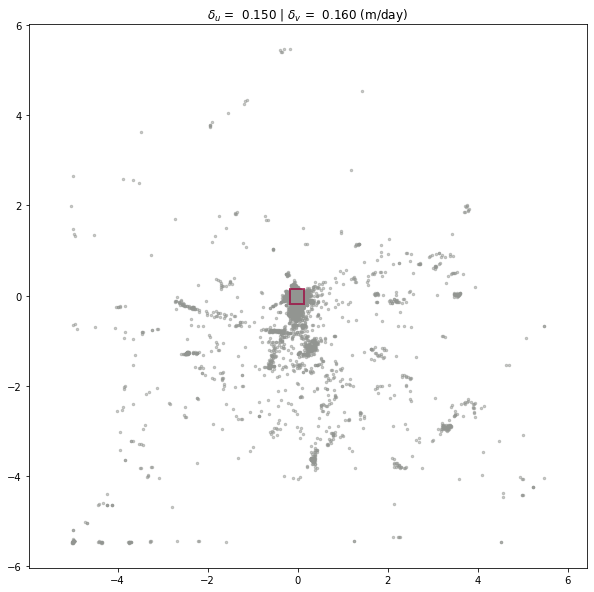

In [9]:
experiment.static_terrain_analysis(plot='full')

If you have performed the analysis and do not want to repeat, you can alternatively use the `plot_full_extent` or `plot_zoomed_extent` method for the same plotting functionality (with the `metric` flag set to 1). 

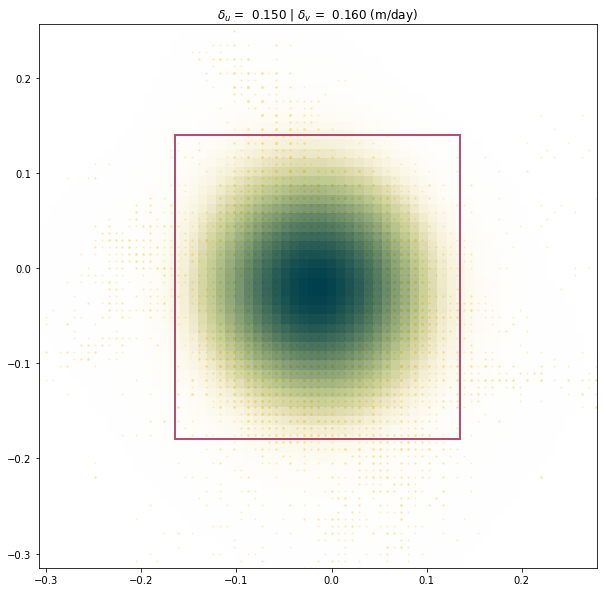

In [10]:
experiment.plot_zoomed_extent(metric=1)

### Metric 2: Along-flow strain rate variability

Again, we start by constructing a `glaft.Velocity` object. Instead of using the `static_area` argument, we pass the polygon file path to the `on_ice_area` argument.

In [11]:
experiment = glaft.Velocity(vxfile=vx, vyfile=vy, on_ice_area=iceflow_area)

And then we can execute the wrapper method `longitudinal_shear_analysis` to calculate Metric 2. This method contains fifteen sub-steps.

In [12]:
experiment.longitudinal_shear_analysis()

Running clip_on_ice_area
Running get_grid_spacing
Running calculate_flow_theta
Running calculate_strain_rate
Running prep_strain_rate_kde
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent


Now the metric are accessible via the following object attributes. Other derived values are also available; see [reference](reference:attr) for detail.

In [13]:
print("delta_x'x': {:.4} (1/day)".format(experiment.metric_alongflow_normal))
print("delta_x'y': {:.4} (1/day)".format(experiment.metric_alongflow_shear))

delta_x'x': 0.001755 (1/day)
delta_x'y': 0.001646 (1/day)


We have the same two ways to visualize the results: setting the `plot` argument for `longitudinal_shear_analysis`, or calling `plot_full_extent` or `plot_zoomed_extent` (with a `metric` argument set to `2`) after `longitudinal_shear_analysis` is executed.

Running clip_on_ice_area
Running get_grid_spacing
Running calculate_flow_theta
Running calculate_strain_rate
Running prep_strain_rate_kde
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent


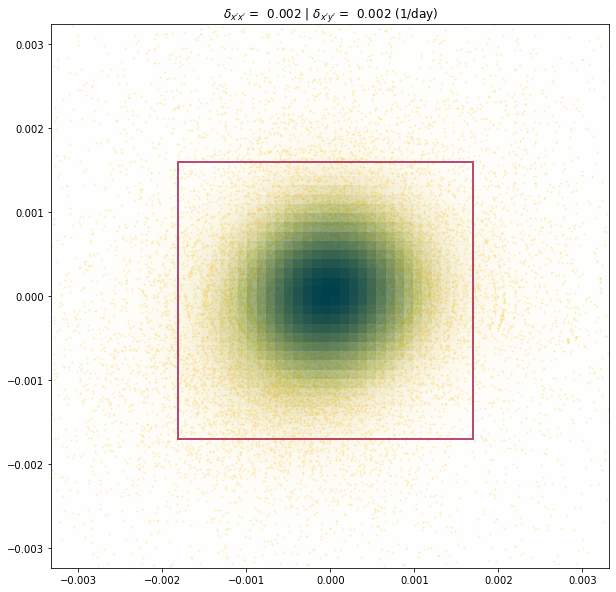

In [14]:
experiment.longitudinal_shear_analysis(plot='zoomed')

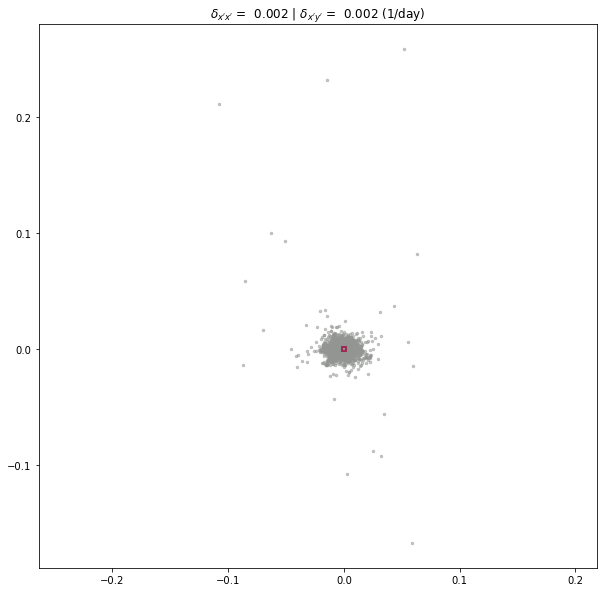

In [15]:
experiment.plot_full_extent(metric=2)

For advanced settings and workflows, please see [reference page](reference) for details.